In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
print(tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

import deepcell
# Changed from before due to new placement of Track, concat_tracks
from deepcell_tracking.utils import load_trks
from deepcell.data.tracking import Track, concat_tracks
##############
from sklearn.model_selection import train_test_split
from deepcell.utils.data_utils import reshape_movie
from deepcell.utils.transform_utils import erode_edges
from deepcell.data import split_dataset
from deepcell_toolbox.processing import normalize, histogram_normalization

import spektral

2.8.0


In [2]:
os.listdir('/training/tracking-nuclear')

['val.trks',
 'inputs.yaml',
 'metadata.yaml',
 'train.trks',
 '.gitignore',
 'params.yaml',
 'dvc.yaml',
 'dvc.lock',
 'data-source.npz',
 'test.trks']

In [3]:
%%time
path_temp_trks = '/training/tracking-nuclear/test.trks'
all_data = [load_trks(path_temp_trks)]

CPU times: user 15.1 s, sys: 1.8 s, total: 16.9 s
Wall time: 16.9 s


In [4]:
%%time
all_tracks = [Track(tracked_data=d) for d in all_data]

100%|███████████████████████████████████████████| 12/12 [00:54<00:00,  4.55s/it]
2022-06-22 06:17:02.954684: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-22 06:17:03.542030: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10415 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:06:00.0, compute capability: 6.1


CPU times: user 7min 27s, sys: 9min 24s, total: 16min 52s
Wall time: 1min 56s


In [5]:
%%time
track_info = concat_tracks(all_tracks)

CPU times: user 312 ms, sys: 556 ms, total: 868 ms
Wall time: 865 ms


# 12 batches, 71 frames for each cell, 331 cells per batch

In [6]:
for k, v in track_info.items():
    print(k, v.shape)

appearances (12, 71, 331, 32, 32, 1)
centroids (12, 71, 331, 2)
morphologies (12, 71, 331, 3)
adj_matrices (12, 71, 331, 331)
norm_adj_matrices (12, 71, 331, 331)
temporal_adj_matrices (12, 70, 331, 331, 3)


# Shuffle not carried out, so images should load in order. The order should be by batch and order in the batch. For example, the first life cycle should be cell 0 in batch 0. The 332nd should be cell 0 in batch 1.

In [7]:
from skimage.exposure import rescale_intensity

def norm(X):
    X_norm = histogram_normalization(X, kernel_size=32)
    
    X_rescaled = np.zeros(X_norm.shape)
    for batch in range(X.shape[0]):
        for frame in range(X.shape[1]):
            x = X[batch, frame]
            x = rescale_intensity(x, out_range=(0,1))
            X_rescaled[batch, frame] = x
            
    return X_rescaled

def prepare_dataset(track_info, batch_size=1, buffer_size=256,
                    seed=None, val_split=0.2):
    
    # Merge tracks along the batch axis
    appearances = track_info['appearances']
    
    app_shape = np.shape(appearances)
    appearances = np.swapaxes(appearances, 1,2) #(0,2,1,3,4,5))
    appearances = np.reshape(appearances, [-1, app_shape[1], app_shape[3], app_shape[4], app_shape[5]])
    
    # Normalize appearances
    appearances = norm(appearances)
    
    input_dict = {'appearances': appearances}
    
    output_dict = {'appearances_decoder': appearances}
    
    dataset = tf.data.Dataset.from_tensor_slices((input_dict, output_dict))
    
    # dataset = dataset.shuffle(buffer_size, seed=seed)
    
    # split into train/val
    # need to add test_data since split_dataset now creates a test dataset
    # test_size is 0 by default
    train_data, val_data, test_data = split_dataset(dataset, val_split)
    
    # batch the data
    train_data = train_data.repeat().batch(batch_size)
    val_data = val_data.repeat().batch(batch_size)
    data = dataset.repeat().batch(batch_size)
    
    # prefetch the data
    train_data = train_data.prefetch(tf.data.AUTOTUNE)
    val_data = val_data.prefetch(tf.data.AUTOTUNE)
    data = dataset.prefetch(tf.data.AUTOTUNE)
    
    return train_data, val_data

# The entire dataset is loaded into train_data (nothing in val_data, since val_split = 0).

In [8]:
train_data, val_data = prepare_dataset(track_info, batch_size=1, val_split=0)

In [10]:
it = iter(train_data)

# This is the first life cycle in the data

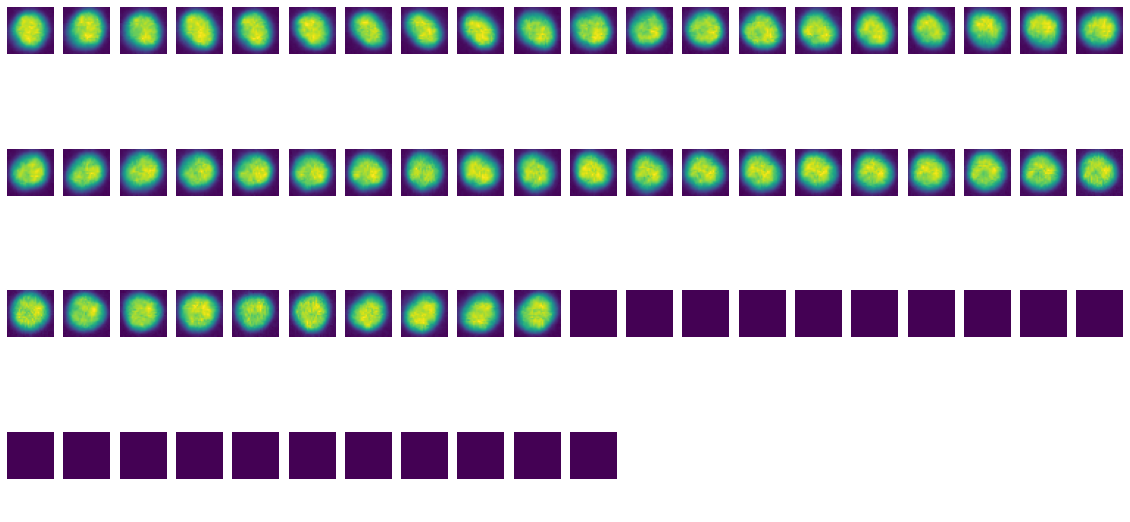

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4,20,figsize=(20,10))

for ax in axes.flatten():
    ax.set_axis_off()
    
nxt = it.next()
for j in range(71):
    axes.flatten()[j].imshow(nxt[0]['appearances'][0,j])
    axes.flatten()[j].set_axis_off()

# The first life cycle does not match with the first one in track_info, but the second one.

/tmp/ipykernel_357/2980973897.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


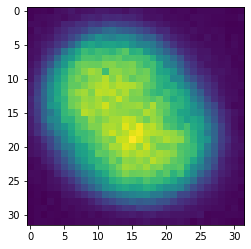

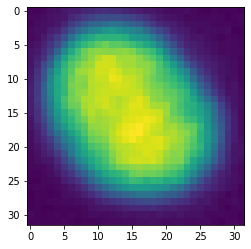

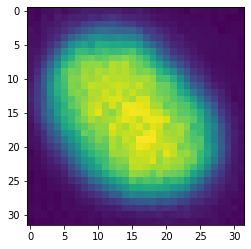

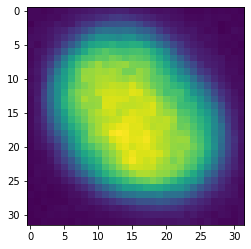

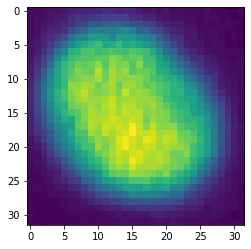

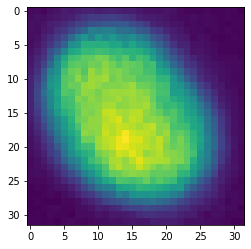

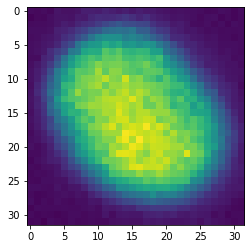

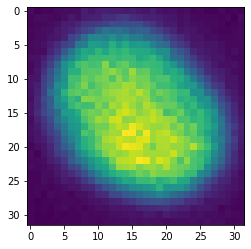

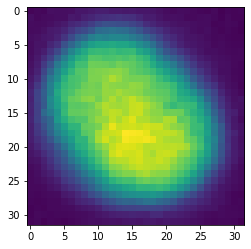

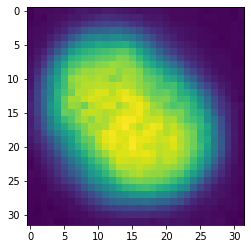

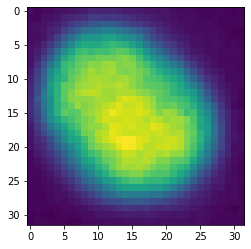

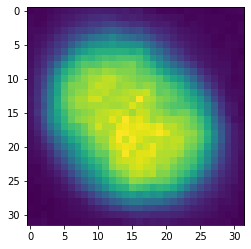

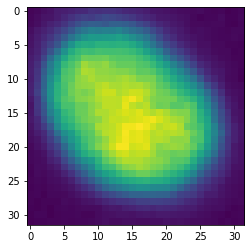

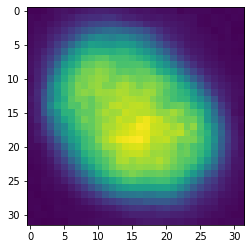

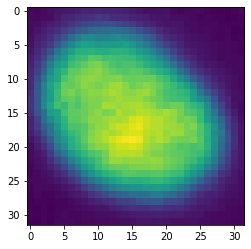

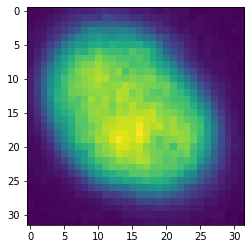

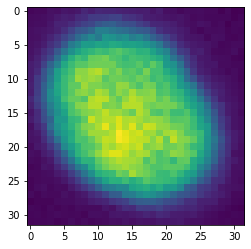

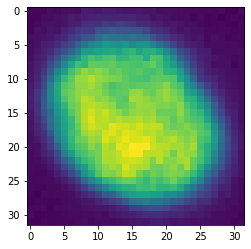

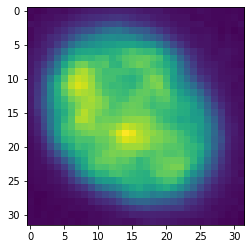

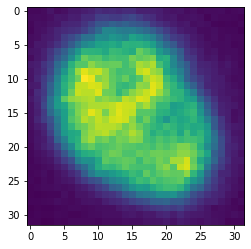

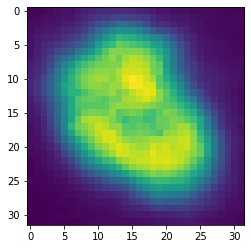

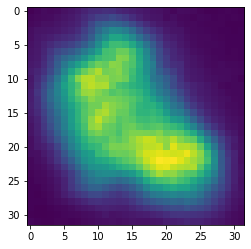

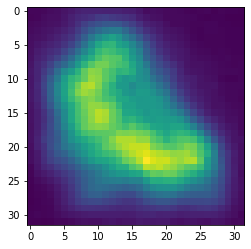

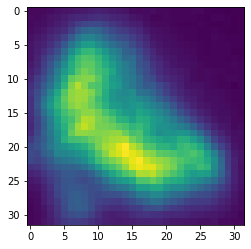

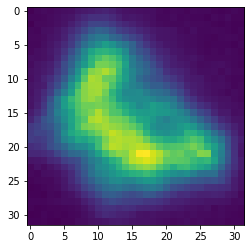

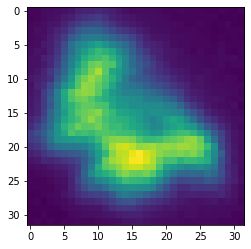

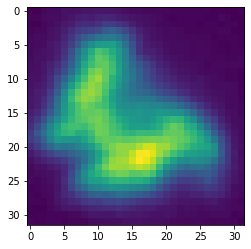

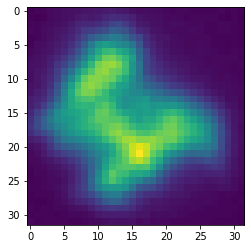

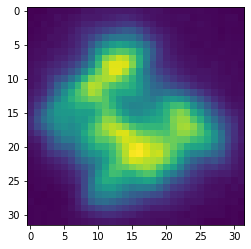

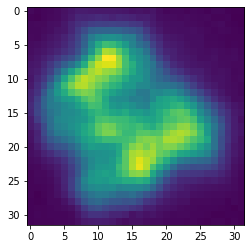

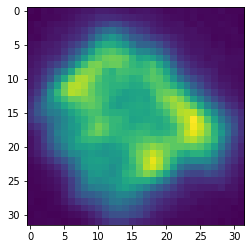

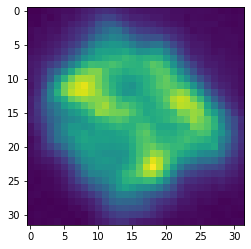

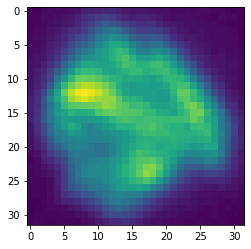

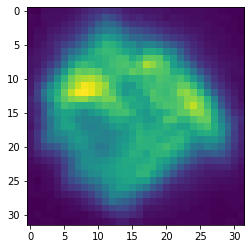

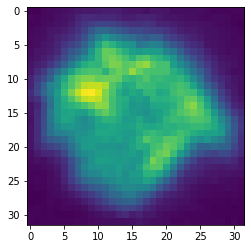

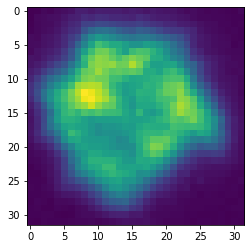

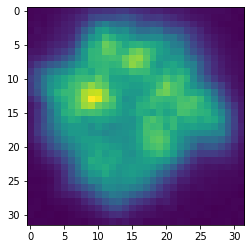

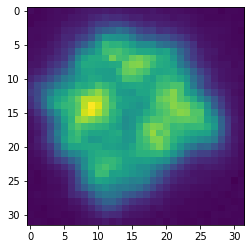

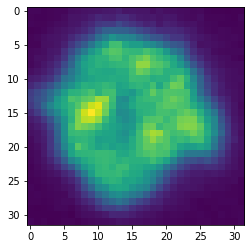

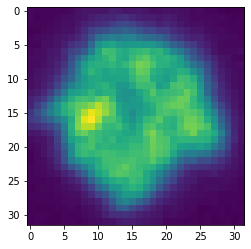

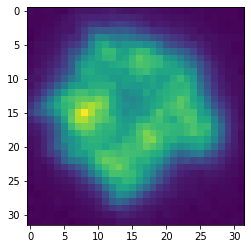

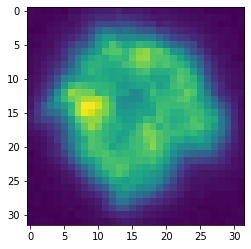

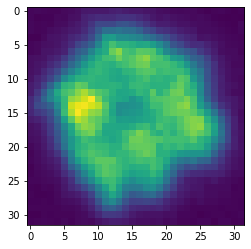

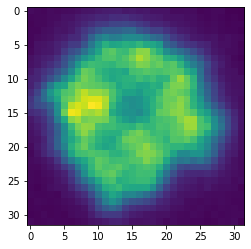

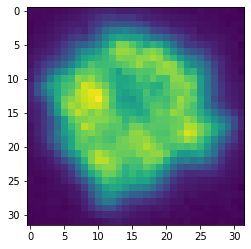

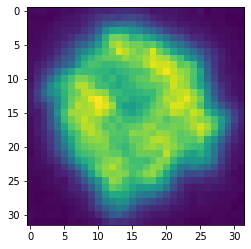

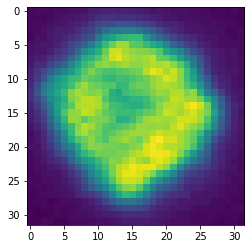

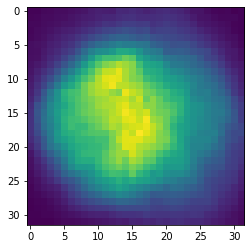

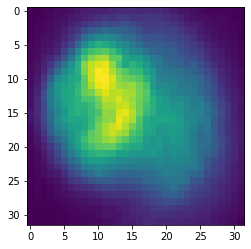

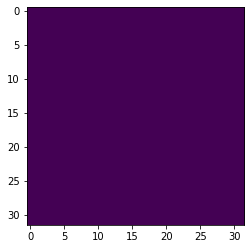

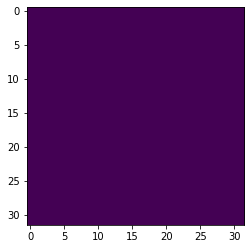

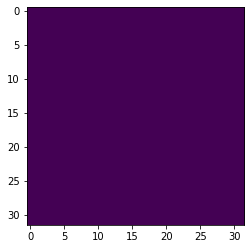

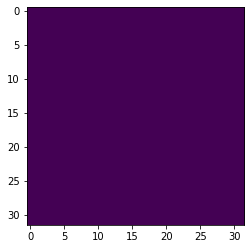

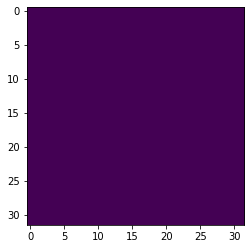

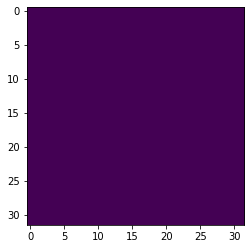

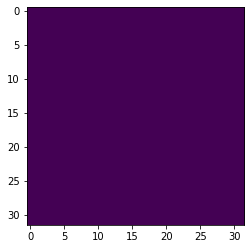

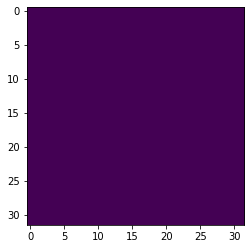

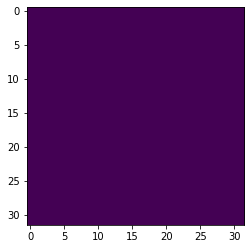

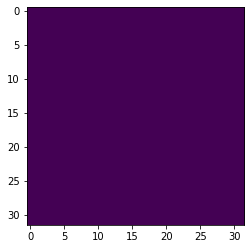

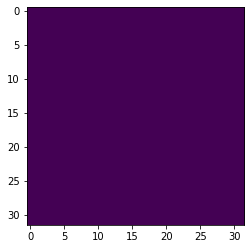

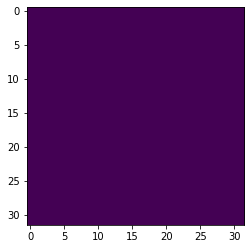

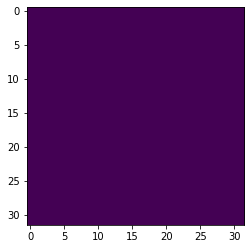

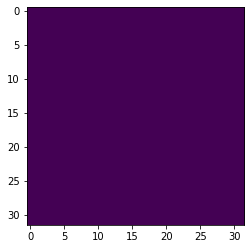

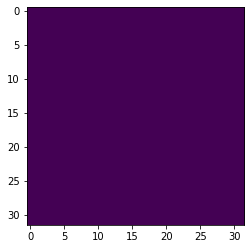

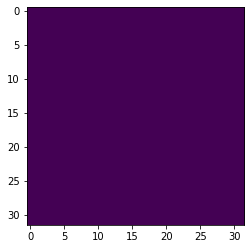

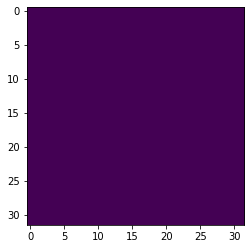

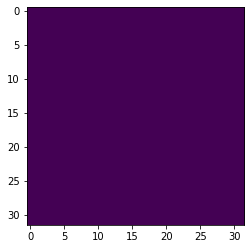

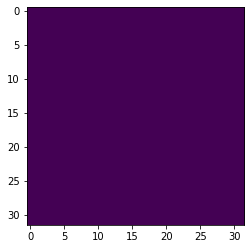

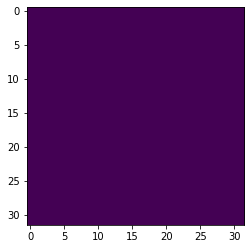

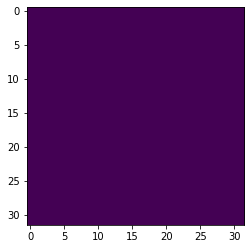

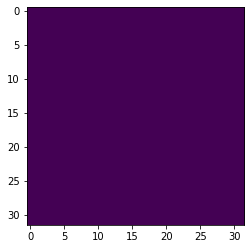

In [12]:
for i in range(71):
    fig, ax = plt.subplots()
    ax.imshow(track_info['appearances'][0][i][0])

/tmp/ipykernel_357/1247729284.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


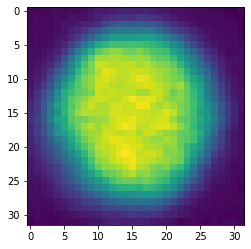

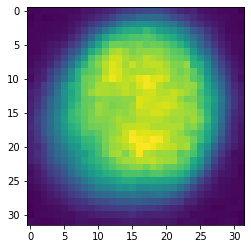

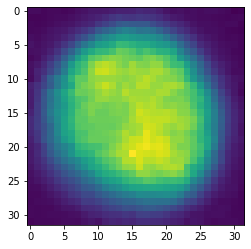

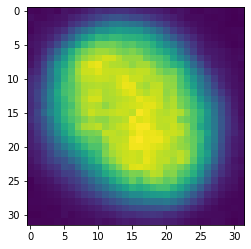

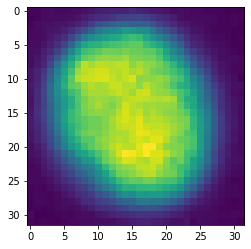

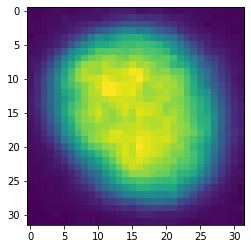

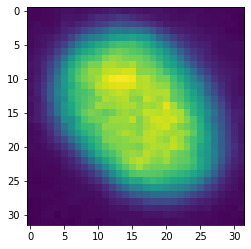

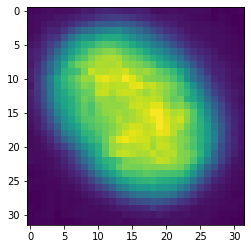

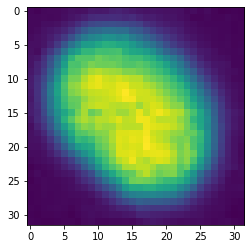

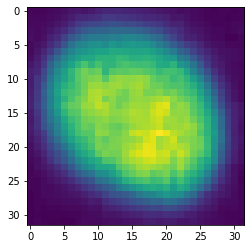

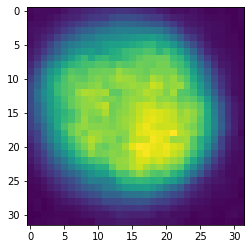

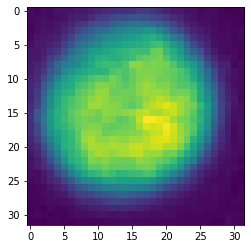

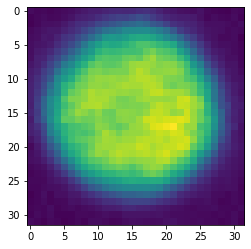

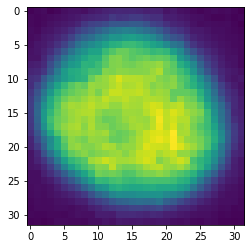

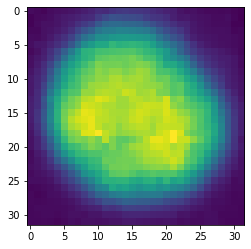

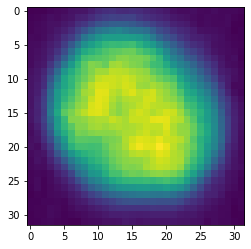

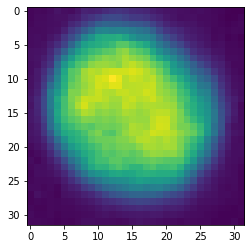

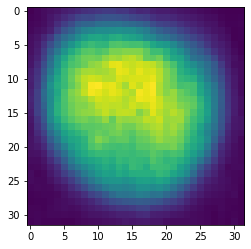

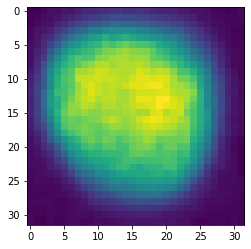

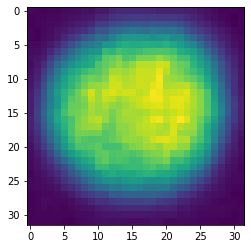

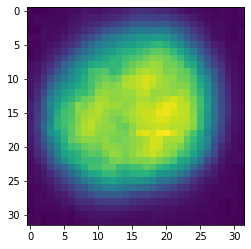

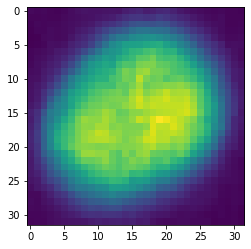

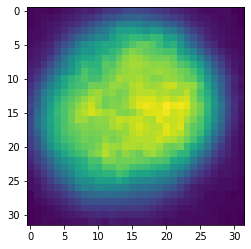

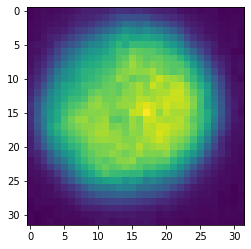

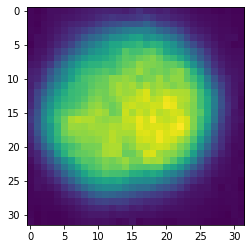

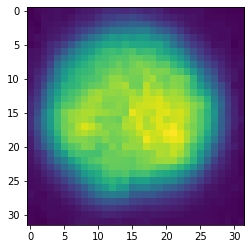

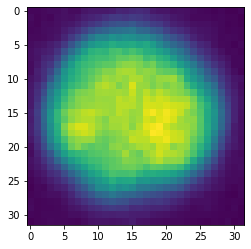

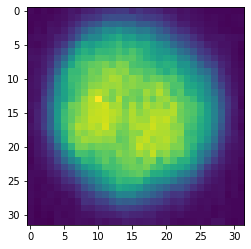

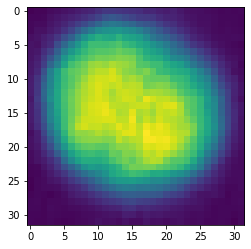

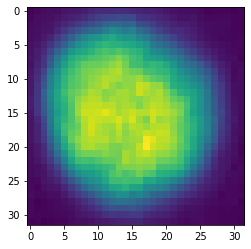

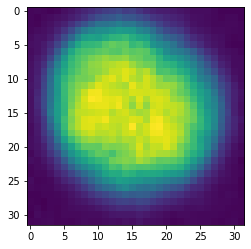

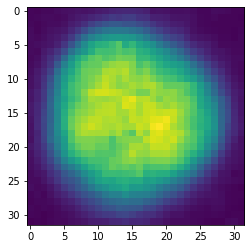

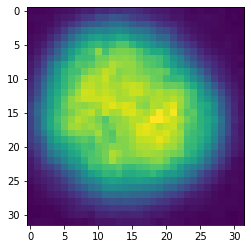

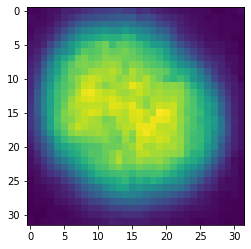

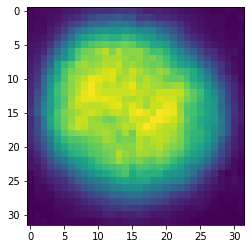

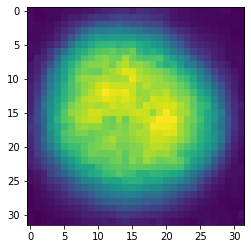

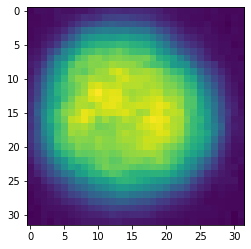

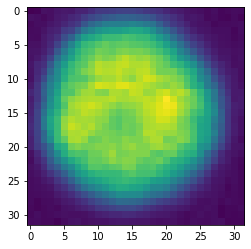

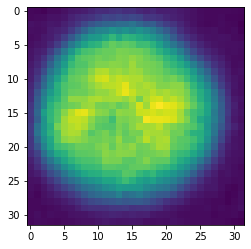

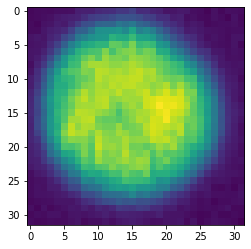

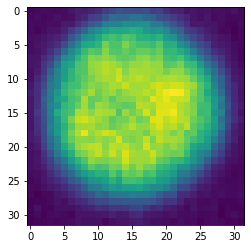

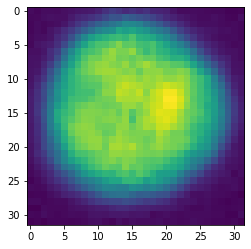

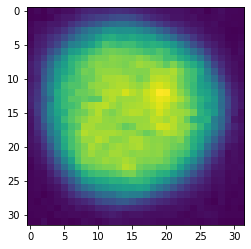

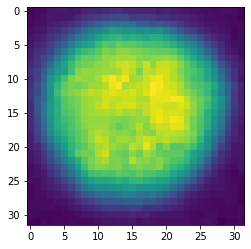

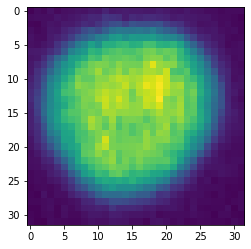

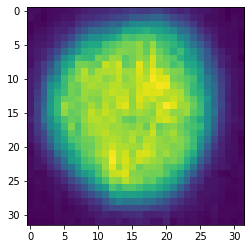

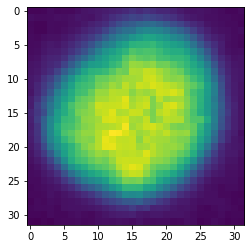

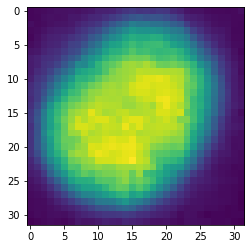

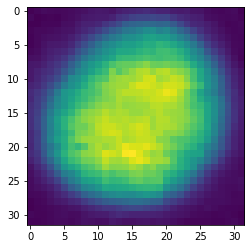

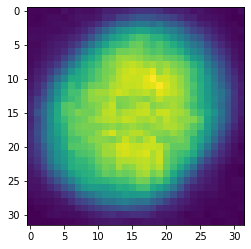

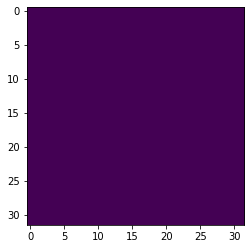

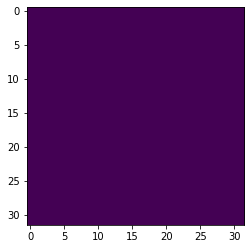

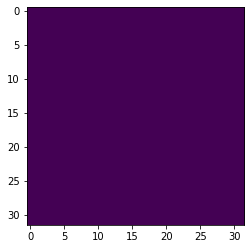

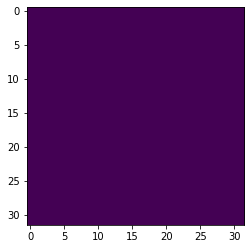

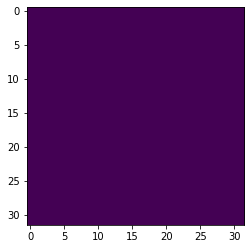

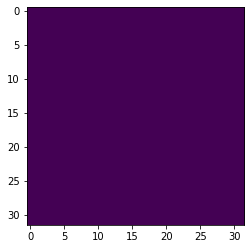

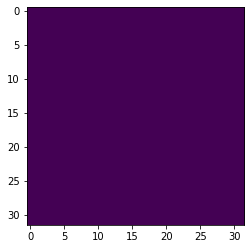

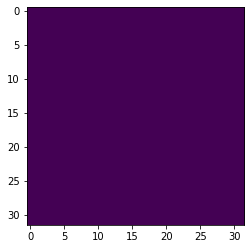

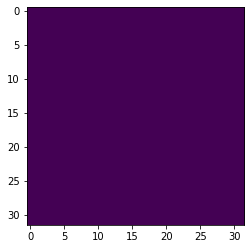

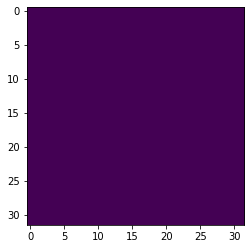

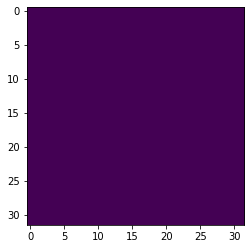

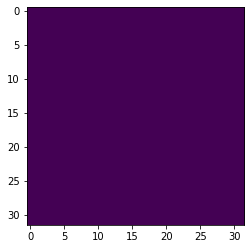

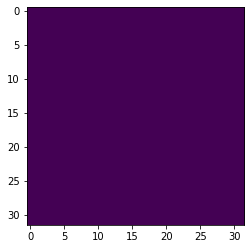

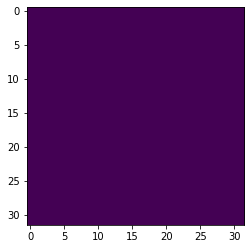

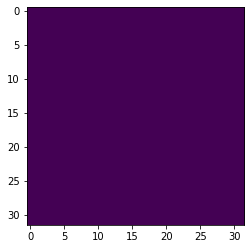

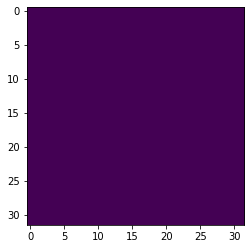

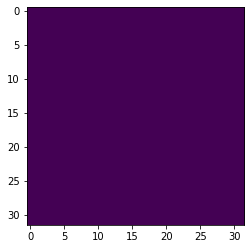

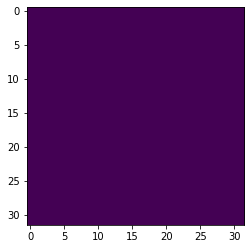

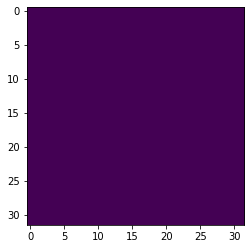

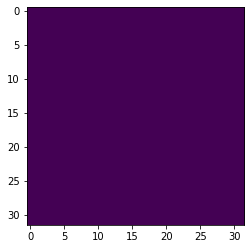

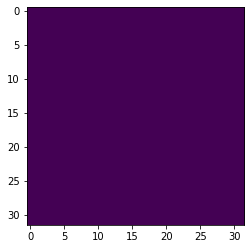

In [13]:
for i in range(71):
    fig, ax = plt.subplots()
    ax.imshow(track_info['appearances'][0][i][1])

/tmp/ipykernel_357/2298922011.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


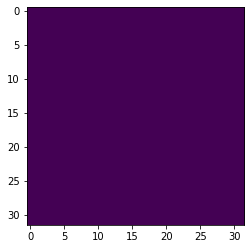

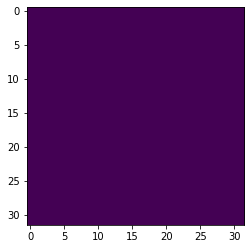

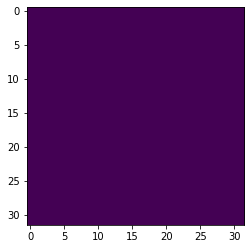

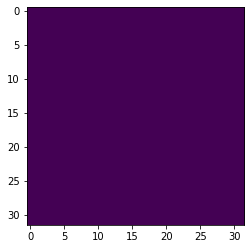

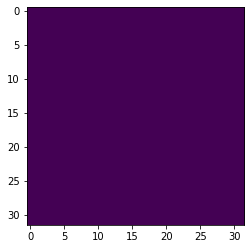

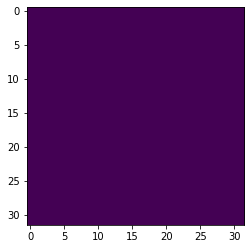

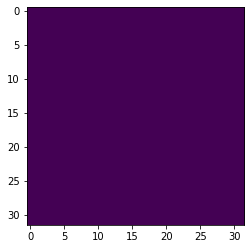

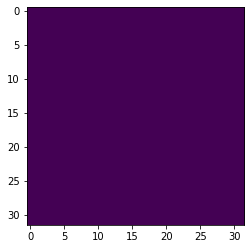

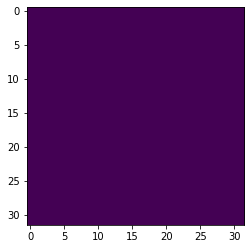

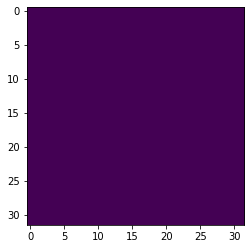

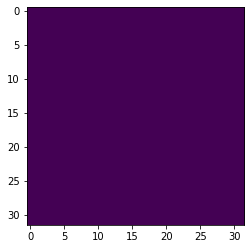

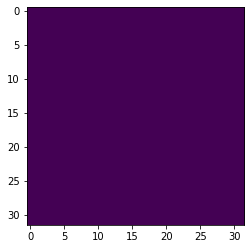

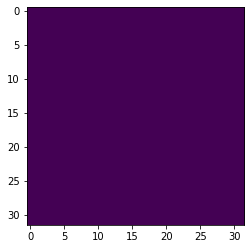

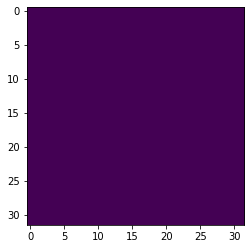

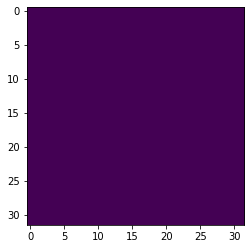

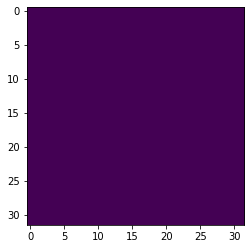

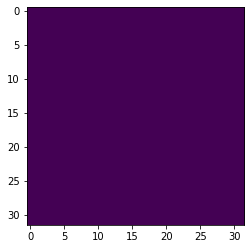

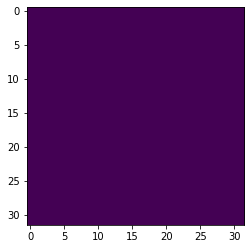

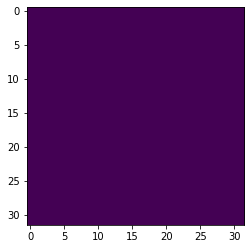

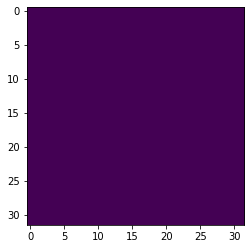

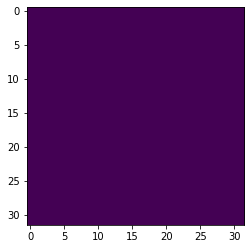

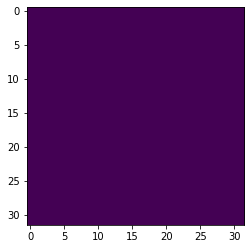

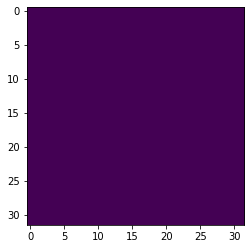

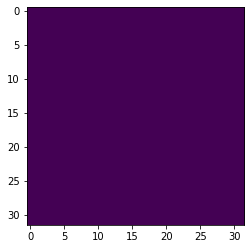

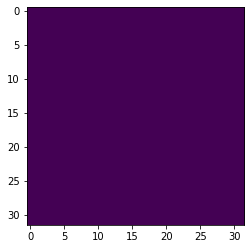

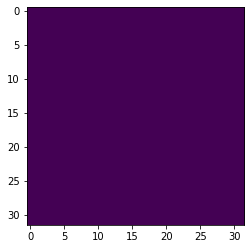

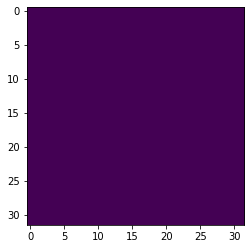

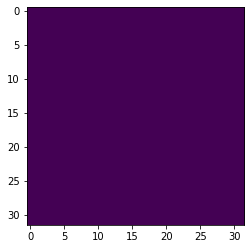

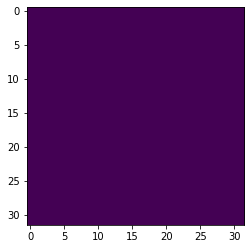

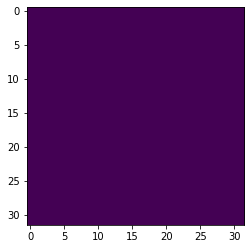

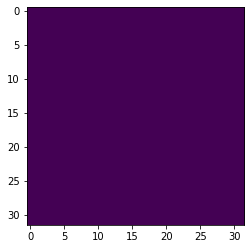

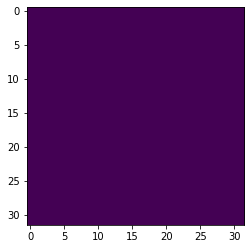

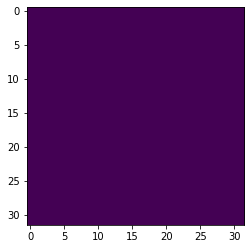

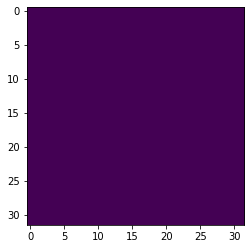

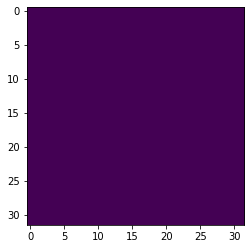

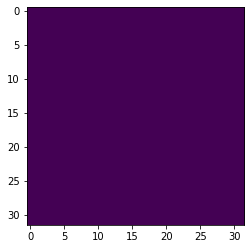

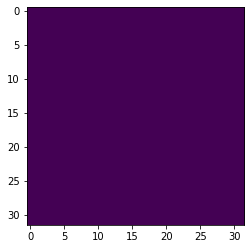

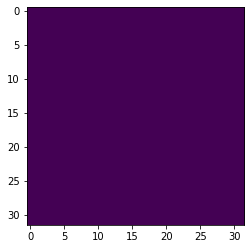

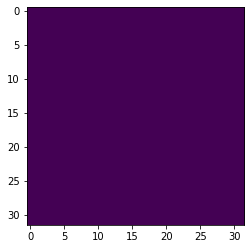

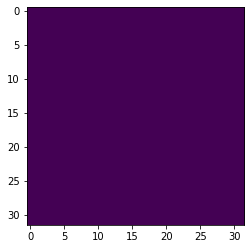

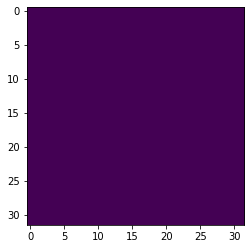

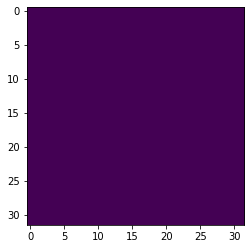

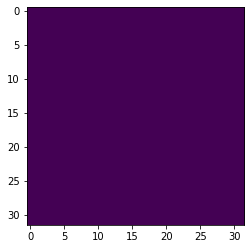

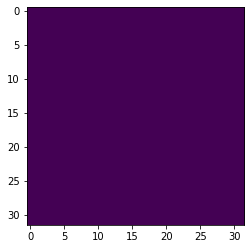

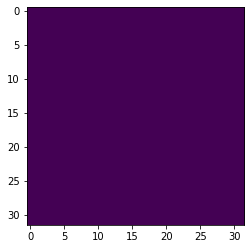

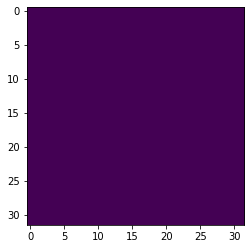

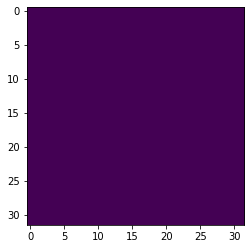

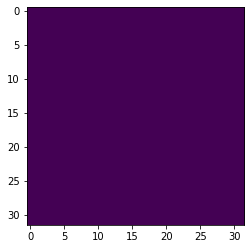

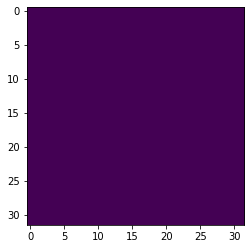

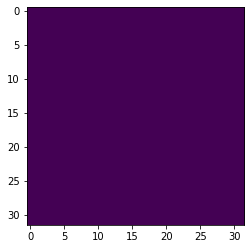

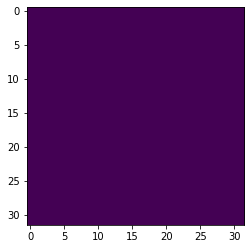

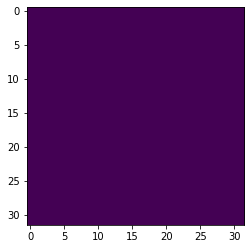

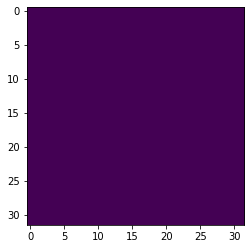

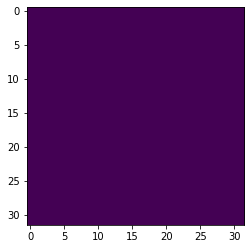

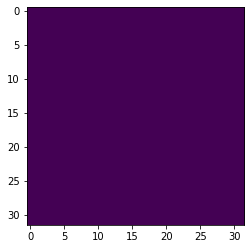

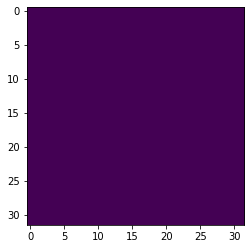

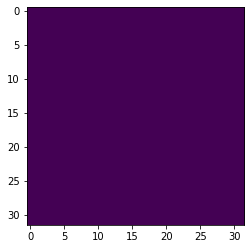

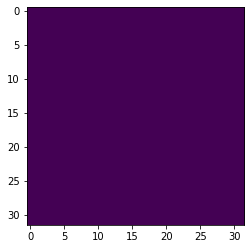

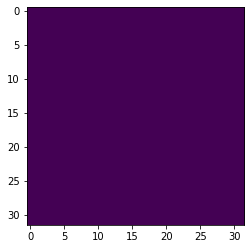

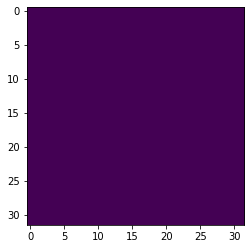

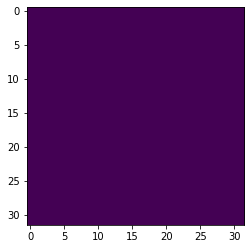

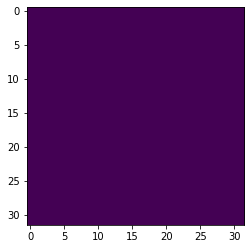

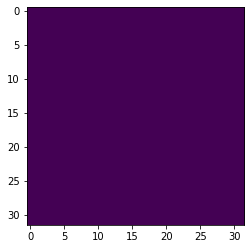

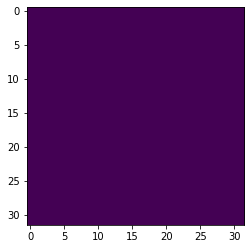

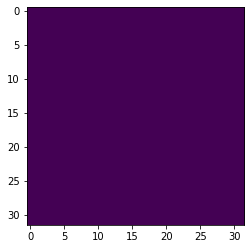

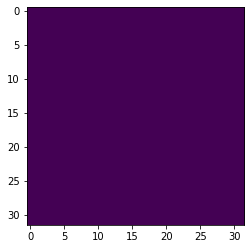

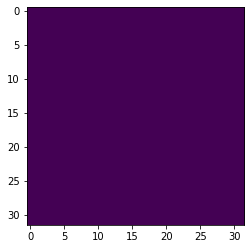

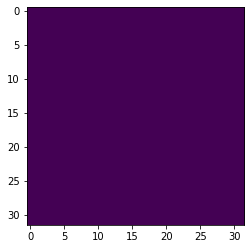

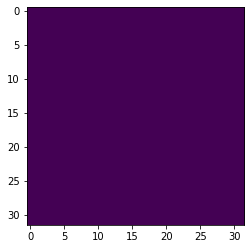

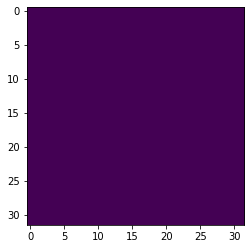

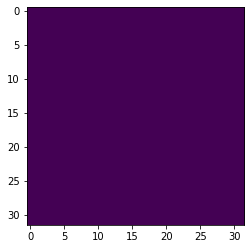

In [14]:
for i in range(71):
    fig, ax = plt.subplots()
    ax.imshow(track_info['appearances'][0][i][100])

# This is the first cell of the second batch, which should be the 332nd life cycle in the iterator.

/tmp/ipykernel_357/2969254018.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


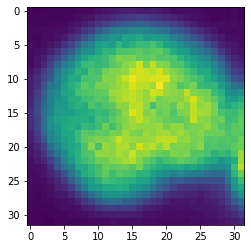

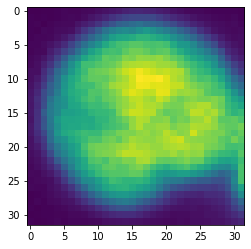

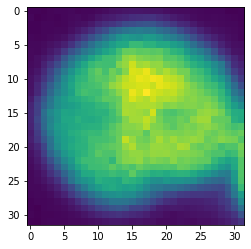

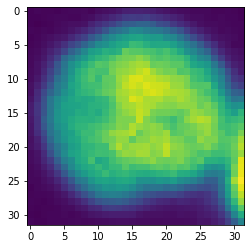

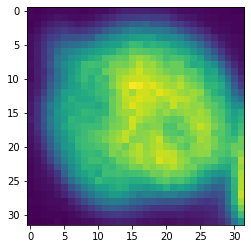

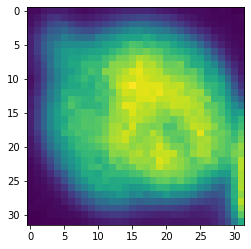

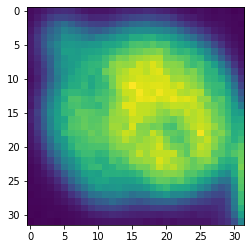

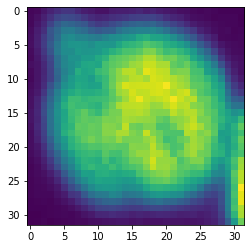

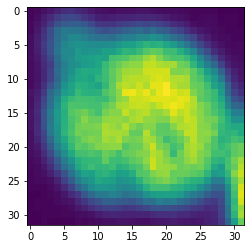

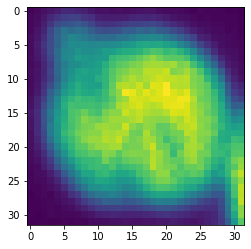

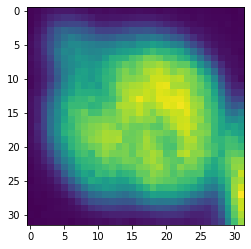

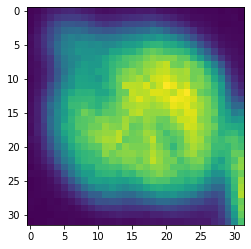

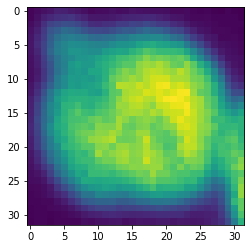

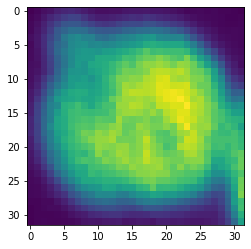

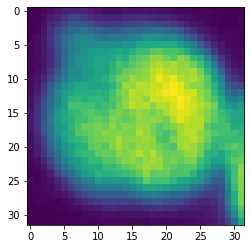

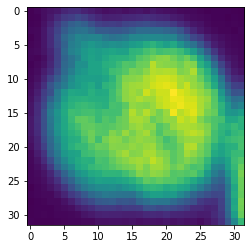

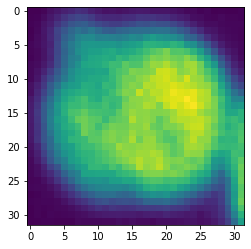

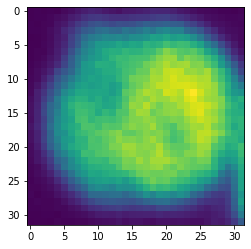

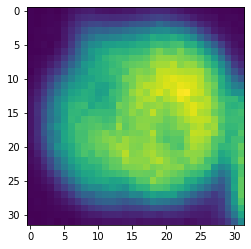

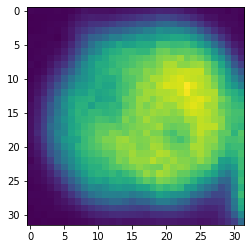

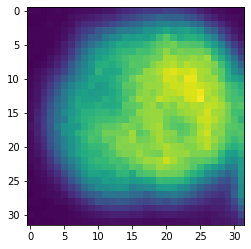

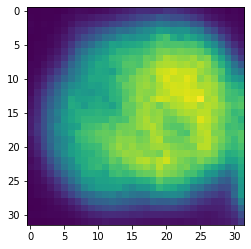

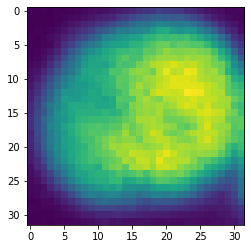

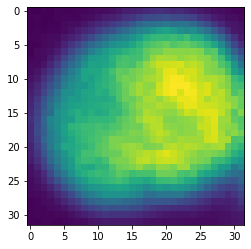

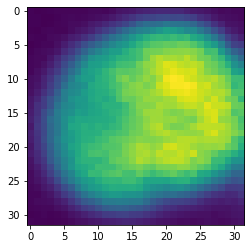

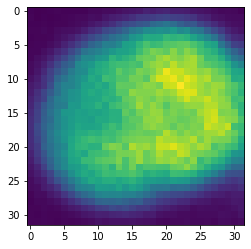

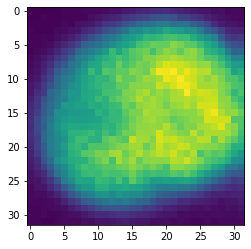

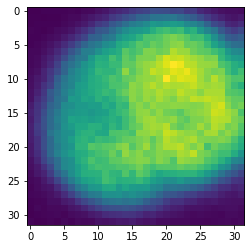

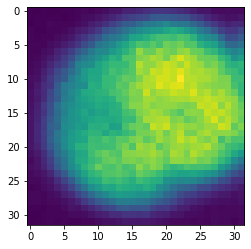

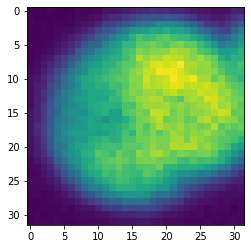

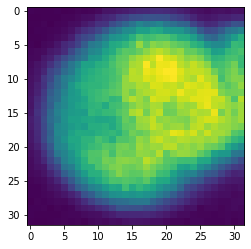

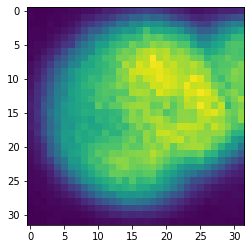

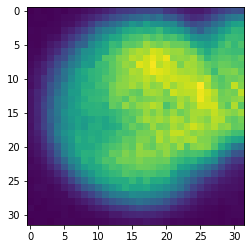

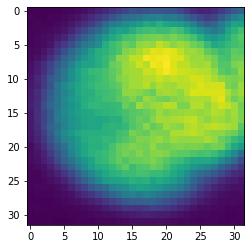

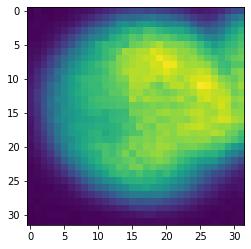

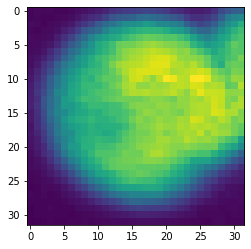

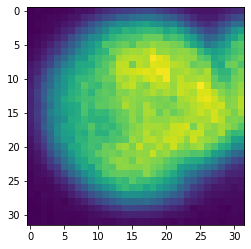

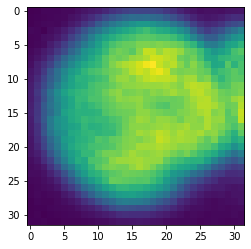

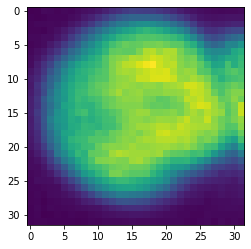

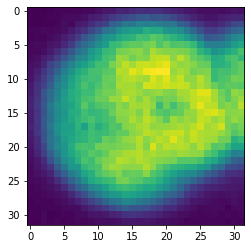

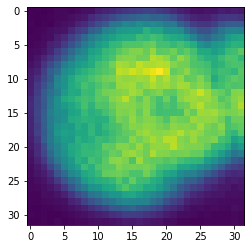

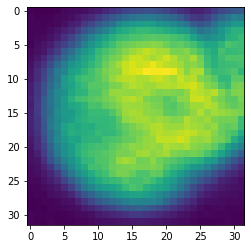

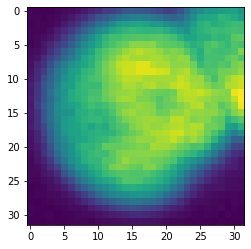

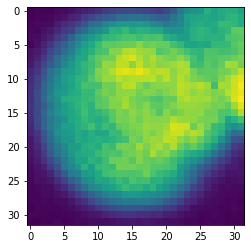

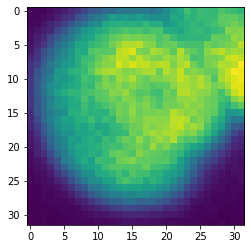

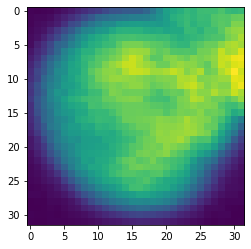

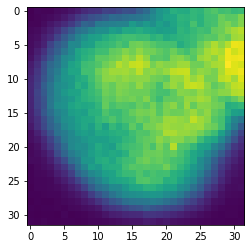

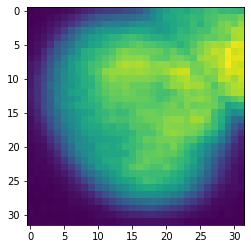

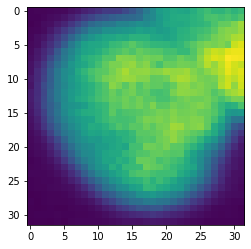

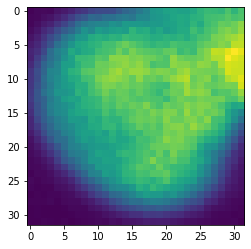

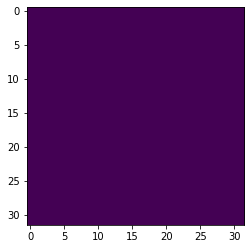

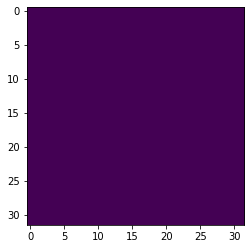

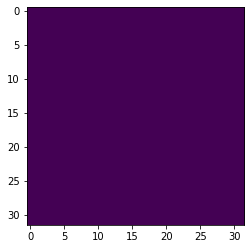

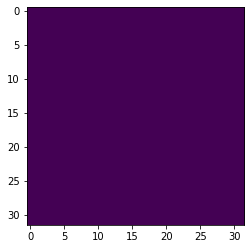

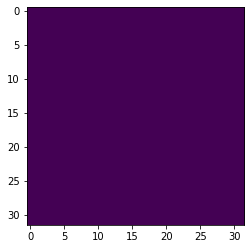

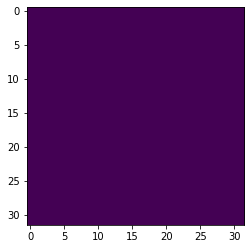

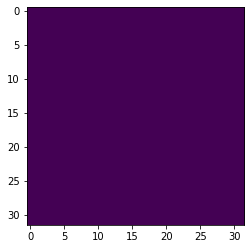

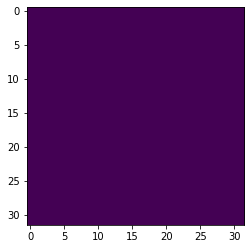

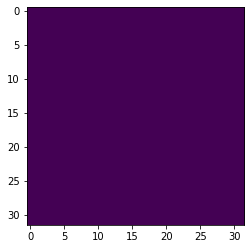

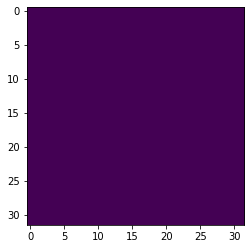

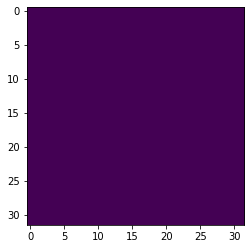

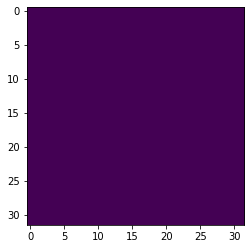

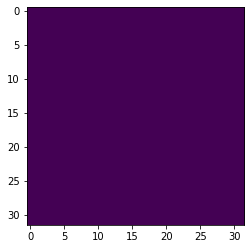

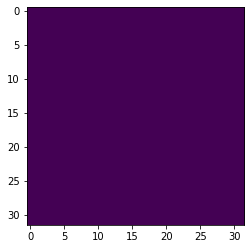

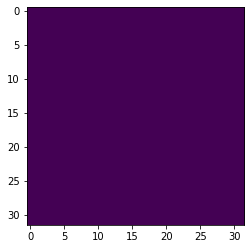

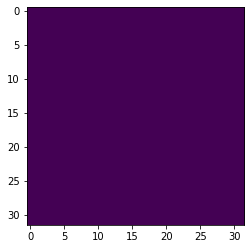

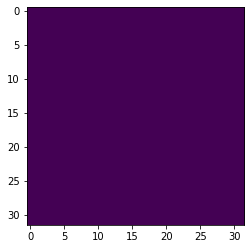

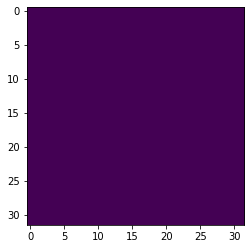

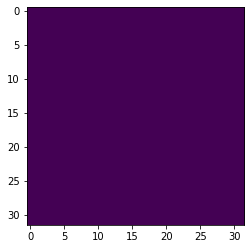

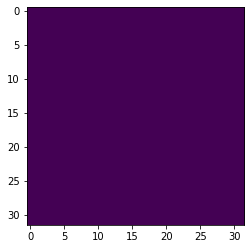

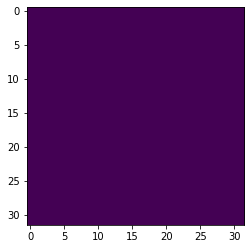

In [30]:
for i in range(71):
    fig, ax = plt.subplots()
    ax.imshow(track_info['appearances'][1][i][0])

# It is the 328th. Some cells may be being skipped, somehow (like the first).

In [26]:
it = iter(train_data)

for i in range(328):
    nxt = it.next()

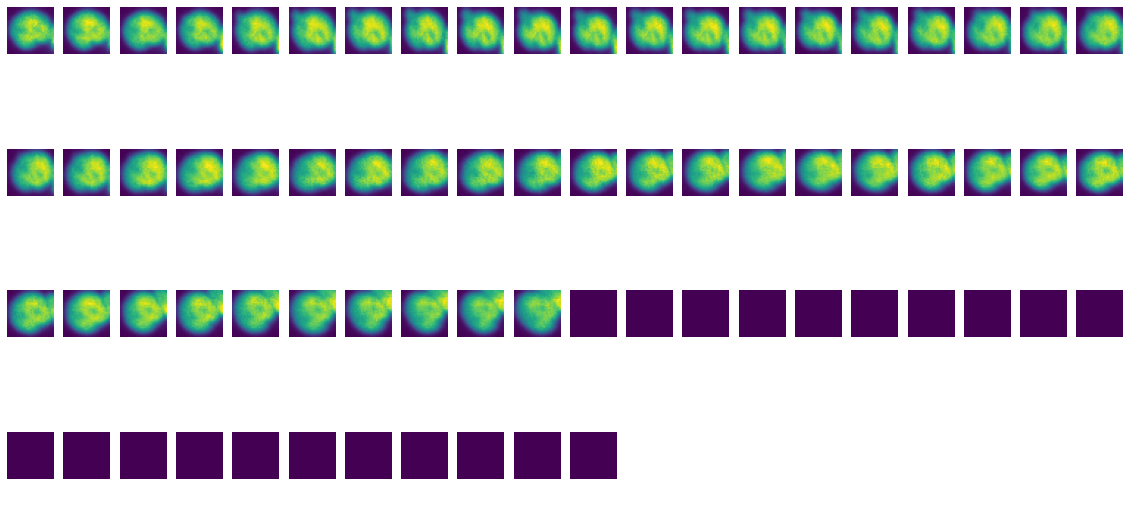

In [27]:
fig, axes = plt.subplots(4,20,figsize=(20,10))

for ax in axes.flatten():
    ax.set_axis_off()

for j in range(71):
    axes.flatten()[j].imshow(nxt[0]['appearances'][0,j])
    axes.flatten()[j].set_axis_off()

# Basically, without the shuffle, the dataset is loaded in order. It seems to be skipping the first cell of the first batch, and possibly others.

# Also, a lot of the cells in some of the batches seem to be nonexistent. One or a few of the batches probably have a lot more cells than the others.